# Recommender Systems

Recommender Systems have become ubiquitous in the modern data science landscape, as companies like Google, Netflix, Pandora, Facebook, etc. rely heavily on them to provide targeted content recommendation to their users to create a more enjoyable user experience.  In these exercises, we'll focus on the process of ***collaborative filtering*** for building recommenders on 2 different datasets (beers and movies).  

[Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) relies on a ***ratings matrix*** for all items to generate similarities between items and users based on similar ratings.  It's important to remember that collaborative filtering is one of the 2 main ways to conduct recommendation, the other being [Content-Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering) which explicitly maps items and/or users into a shared feature space based on explicit user/item characteristics.  State of the art recommenders will often rely on hybrid approaches of these 2, so it's important to understand the differences, strengths, and weaknesses of each and what separates them.

### Datasets
- [Beer Ratings](https://github.com/pburkard88/DS_BOS_06/blob/master/Data/beer_reviews.tar.gz): A dataset of beer reviews
- [Movielens Data](https://github.com/pburkard88/DS_BOS_06/blob/master/Data/movielens): A dataset of movie ratings from the original [here](http://grouplens.org/datasets/movielens/)

### Learning Goals
- Perform collaborative filtering from ratings matrices using `pandas` and `sklearn` on the beers data
- Understand why this approach represents collaborative filtering
- Understand how SVDs or other matrix decompositions might fit in in the context of a recommender algorithm

## Similarity based Recommendation System: Beers
The first dataset we'll work with is a list of many beer reviews by a variety of reviewers with accompanying beer metadata on every review.  We'll use this data to generate our reviewer/beer ratings matrix from which we can perform collaborative filtering and recommend beers based on user preferences.

### Beers: Get the Data
First perform the usual imports of `numpy` and `pandas` as `np` and `pd`.

In [2]:
import pandas as pd
import numpy as np

Now let's get the data.  If you don't already have it locally you can use curl to pull it down.

In [ ]:
#! curl -O https://s3.amazonaws.com/demo-datasets/beer_reviews.tar.gz

These steps here are optional, just move the data some place where you know where it is and then point your eventual call to `read_csv()` to that location.

In [ ]:
#! tar -xvzf beer_reviews.tar.gz

In [ ]:
# !ls beer_reviews

Import the data into a `pandas` dataframe called `df` by calling `read_csv()` with the appropriate path and the parameter `compression='gzip'` (you don't need this if you already extracted your file, it's just nice to see that pandas can handle gzipped data).

In [3]:
#df = pd.read_csv("~/data/beer_reviews.tar.gz", compression='gzip', error_bad_lines=False)
df = pd.read_csv("./data/beer_reviews/beer_reviews.csv")


### Explore the Data
Let's look at the data with `head()`

In [4]:
df.shape

(1586614, 13)

In [4]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


Create a separate data frame `df_test` to investigate a little bit further by selecting out only the **beer_name="Pale Ale"** reviews using the `isIn([])` function.  Then sort this resulting table by **review_profilename** and examine the first 20 rows.  You should notice that the same reviewer can review multiple Pale Ales.

In [5]:
df_test = df[df.beer_name.isin(['Pale Ale'])].sort_values(by='review_profilename')
df_test[['review_profilename','beer_name','review_overall']].head(20)

,review_profilename,beer_name,review_overall
912451,0110x011,Pale Ale,4.0
1406262,1759Girl,Pale Ale,3.5
563154,1Adam12,Pale Ale,3.5
525342,1fastz28,Pale Ale,4.5
41264,321jeff,Pale Ale,4.0
1385721,3Vandoo,Pale Ale,3.5
562967,7thstreetbrewery,Pale Ale,5.0
563116,ADR,Pale Ale,4.0
477535,ADZA,Pale Ale,4.5
1429227,ADZA,Pale Ale,3.0


Let's restrict this to the top 250 beers. Use the `value_counts()` method to get a sorted list by value count on **beer_name** and then taking the first 250.  Overwrite `df` with this new data.

In [6]:
df.beer_name.value_counts()

90 Minute IPA                                               3290
India Pale Ale                                              3130
Old Rasputin Russian Imperial Stout                         3111
Sierra Nevada Celebration Ale                               3000
Two Hearted Ale                                             2728
Arrogant Bastard Ale                                        2704
Stone Ruination IPA                                         2704
Sierra Nevada Pale Ale                                      2587
Stone IPA (India Pale Ale)                                  2575
Pliny The Elder                                             2527
Founders Breakfast Stout                                    2502
Pale Ale                                                    2500
Sierra Nevada Bigfoot Barleywine Style Ale                  2492
La Fin Du Monde                                             2483
60 Minute IPA                                               2475
Storm King Stout         

In [7]:
n = 250
top_n = df.beer_name.value_counts().index[:n]
df = df[df.beer_name.isin(top_n)]
df[['review_profilename','beer_name','review_overall']].head(10)

,review_profilename,beer_name,review_overall
798,grumpy,Imperial Stout,4.5
1559,blitheringidiot,Pale Ale,4.0
1560,NeroFiddled,Pale Ale,4.0
1563,blitheringidiot,IPA,3.5
1564,Gavage,IPA,3.0
1565,NeroFiddled,IPA,4.5
1566,weeare138,IPA,4.0
1636,JamesS,Oktoberfest,4.0
1637,danielocean03,Oktoberfest,4.5
1638,BlackAngus,Oktoberfest,4.5


How big is this dataset?  Use `df.info()`

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355275 entries, 798 to 1586564
Data columns (total 13 columns):
brewery_id            355275 non-null int64
brewery_name          355275 non-null object
review_time           355275 non-null int64
review_overall        355275 non-null float64
review_aroma          355275 non-null float64
review_appearance     355275 non-null float64
review_profilename    355175 non-null object
beer_style            355275 non-null object
review_palate         355275 non-null float64
review_taste          355275 non-null float64
beer_name             355275 non-null object
beer_abv              353477 non-null float64
beer_beerid           355275 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 37.9+ MB


Aggregate the data in a pivot table called `df_wide` using the `pivot_table` method. Display the mean review_overall for each beer_name aggregating the review_overall values by review_profilename. Use the mean (numpy.mean) as aggregator.  In other words, the `values` parameter should contain **review_overall** and the `index` parameter should contain **beer_name** and **beer_name**.  Make sure to call `unstack()` at the end.

In [9]:
# row is the beer_name and column is the review_profile
df_wide = pd.pivot_table(df, values=["review_overall"],
        index=["beer_name", "review_profilename"],
        aggfunc=np.mean).unstack()
df_wide.shape

(250, 22140)

Display the head of the pivot table, but only for 5 users (columns are users)

In [10]:
df_wide.iloc[0:5, 0:5]

review_overall                               \
review_profilename               0110x011 02maxima 03SVTCobra 05Harley   
beer_name                                                                
#9                                    NaN      NaN        NaN      NaN   
120 Minute IPA                        NaN      NaN        NaN      4.0   
1554 Enlightened Black Ale            NaN      NaN        NaN      NaN   
60 Minute IPA                         NaN      NaN        NaN      NaN   
90 Minute IPA                         5.0      NaN        NaN      4.0   

                                     
review_profilename         0Naught0  
beer_name                            
#9                              NaN  
120 Minute IPA                  NaN  
1554 Enlightened Black Ale      NaN  
60 Minute IPA                   NaN  
90 Minute IPA                   NaN

### Discussion: what do you notice in this table?

Set Nans to zero with the `fillna()` function.

In [11]:
df_wide = df_wide.fillna(0)

In [12]:
df_wide.iloc[0:5, 0:5]

review_overall                               \
review_profilename               0110x011 02maxima 03SVTCobra 05Harley   
beer_name                                                                
#9                                    0.0      0.0        0.0      0.0   
120 Minute IPA                        0.0      0.0        0.0      4.0   
1554 Enlightened Black Ale            0.0      0.0        0.0      0.0   
60 Minute IPA                         0.0      0.0        0.0      0.0   
90 Minute IPA                         5.0      0.0        0.0      4.0   

                                     
review_profilename         0Naught0  
beer_name                            
#9                              0.0  
120 Minute IPA                  0.0  
1554 Enlightened Black Ale      0.0  
60 Minute IPA                   0.0  
90 Minute IPA                   0.0

### Calculate distance between beers

This is the key.  We have our ratings matrix now and we're going to use cosine_similarity from scikit-learn to compute the distance between all beers in this space.

Import stuff

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import manhattan_distances
# from sklearn.metrics.pairwise import euclidean_distances

Apply `cosine_similarity()` to `df_wide` to calculate pairwise distances and store this in a variable called `dists`.

In [14]:
dists = cosine_similarity(df_wide) # all beers against all beers

In [15]:
print(dists.shape)

(250, 250)


Convert dists to a Pandas DataFrame, use the index as column index as well (distances are a square matrix).  This means we'll have a beers by beers matrix of the distances between every beer from the ratings space.  Check out the first 10 or so rows and columns and make sure things look right (should see 1s on the diagonal).

In [16]:
dists = pd.DataFrame(dists, columns=df_wide.index)

dists.index = dists.columns
dists.iloc[0:5, 0:5]

beer_name,#9,120 Minute IPA,1554 Enlightened Black Ale,60 Minute IPA,90 Minute IPA
beer_name,,,,,
#9,1.000000,0.275405,0.274103,0.388364,0.365175
120 Minute IPA,0.275405,1.000000,0.251519,0.378258,0.410366
1554 Enlightened Black Ale,0.274103,0.251519,1.000000,0.319887,0.314028
60 Minute IPA,0.388364,0.378258,0.319887,1.000000,0.533042
90 Minute IPA,0.365175,0.410366,0.314028,0.533042,1.000000


Select some beers and store them in `beers_i_like` then look their distances to other beers with `head()`

In [17]:
beers_i_like = ['Sierra Nevada Pale Ale', '120 Minute IPA', 'Allagash White']
dists[beers_i_like].head()

beer_name,Sierra Nevada Pale Ale,120 Minute IPA,Allagash White
beer_name,,,
#9,0.373968,0.275405,0.340681
120 Minute IPA,0.301693,1.000000,0.282273
1554 Enlightened Black Ale,0.330033,0.251519,0.260275
60 Minute IPA,0.459641,0.378258,0.360975
90 Minute IPA,0.441189,0.410366,0.356804


Sum the distances of my favorite beers by row, to have one distance from each beer in the sample.  For instance if there are 3 beers in your `beers_i_like` then you will be summing 3 numbers for each row.  Store the results in `beers_summed`.  

In [18]:
beers_summed = np.sum(dists[beers_i_like], axis=1)

Sort summed beers from best to worse using `order()`

In [19]:
beers_summed = beers_summed.sort_values(ascending=False)
beers_summed

beer_name
Sierra Nevada Pale Ale                        1.654205
Allagash White                                1.634784
120 Minute IPA                                1.583966
HopDevil Ale                                  1.224217
Sierra Nevada Celebration Ale                 1.215156
90 Minute IPA                                 1.208359
60 Minute IPA                                 1.198874
Stone Ruination IPA                           1.194210
Stone IPA (India Pale Ale)                    1.193193
Storm King Stout                              1.192405
Arrogant Bastard Ale                          1.189981
Sierra Nevada Bigfoot Barleywine Style Ale    1.178245
Prima Pils                                    1.178093
Brooklyn Black Chocolate Stout                1.156365
Ayinger Celebrator Doppelbock                 1.148356
Hennepin (Farmhouse Saison)                   1.147501
Samuel Adams Boston Lager                     1.146304
Hop Rod Rye                                   1.140271


Filter out the beers used as input using `isin()` and store this in `ranked_beers`, then transform this to a list using `tolist()`.  Print out the first 5 elements.

In [20]:
ranked_beers = beers_summed.index[beers_summed.index.isin(beers_i_like)==False]
ranked_beers = ranked_beers.tolist()
ranked_beers[:5]

['HopDevil Ale',
 'Sierra Nevada Celebration Ale',
 '90 Minute IPA',
 '60 Minute IPA',
 'Stone Ruination IPA']

Define a function that does what we just did for an arbitrary input list of beers. it should also receive the maximum number of beers requested n as optional parameter.

In [21]:
def get_similar(beers, n=None):
    """
    calculates which beers are most similar to the beers provided. Does not return
    the beers that were provided
    
    Parameters
    ----------
    beers: list
        some beers!
    
    Returns
    -------
    ranked_beers: list
        rank ordered beers
    """
    beers = [beer for beer in beers if beer in dists.columns]
    beers_summed = dists[beers].apply(lambda row: np.sum(row), axis=1).sort_values(ascending=False)
    ranked_beers = beers_summed.index[beers_summed.index.isin(beers)==False]
    ranked_beers = ranked_beers.tolist()
    if n is None:
        return ranked_beers
    else:
        return ranked_beers[:n]

Test your function. Find the 10 beers most similar to "Corona Extra"

In [22]:
for beer in get_similar(["Corona Extra"], 10):
    print(beer)

Heineken Lager Beer
Budweiser
Bud Light
Coors Light
Stella Artois
Samuel Adams Boston Lager
Red Stripe Jamaican Lager
Blue Moon Belgian White
Guinness Draught
Bass Pale Ale


Cool, let's try again with the 10 beers most similar to ["Coors Light", "Bud Light", "Amstel Light"]

In [23]:
for i, beer in enumerate(get_similar(["Coors Light", "Bud Light", "Amstel Light"], 10)):
    print("%d) %s" % (i+1, beer))

1) Miller Lite
2) Budweiser
3) Corona Extra
4) Samuel Adams Boston Lager
5) Heineken Lager Beer
6) Blue Moon Belgian White
7) Guinness Draught
8) Miller High Life
9) Samuel Adams Summer Ale
10) Sierra Nevada Pale Ale


## Movie Recommendations
We'll make movie recommendations from the [movielens dataset](http://grouplens.org/datasets/movielens/).  

### Get the Data
Download the movielens dataset [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) 

Let's look at the files, you can do this however you like.

In [ ]:
# ! unzip ml-latest-small.zip

Read in the movies.csv data into a variable `movies` by using `pd.read_csv` 

In [25]:
movies = pd.read_csv('/Users/robertomac/Downloads/ml-latest-small/movies.csv', index_col= 'movieId')

### Explore the Data
Take a look at the movies data with `head()`.

In [26]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Load the ratings.csv data into a `ratings` dataframe.

In [27]:
ratings = pd.read_csv('/Users/robertomac/Downloads/ml-latest-small/ratings.csv')

In [28]:
ratings.shape

(100004, 4)

In [29]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [30]:
print('Number of Users:')
print((ratings.groupby(['userId']).count()).shape[0])
print('Number of Movies:')
print((ratings.groupby(['movieId']).count()).shape[0])
print('Number of Reviews:')
print(ratings.shape[0])

Number of Users:
671
Number of Movies:
9066
Number of Reviews:
100004


In [31]:
ratings.groupby(['rating'])['userId'].count()

rating
0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: userId, dtype: int64

In [32]:
ratings_pivot = pd.pivot_table(ratings, index='userId', columns='movieId', values='rating', aggfunc=np.mean)
ratings_pivot = ratings_pivot.fillna(0) # Replace NA's with 0
ratings_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings_pivot.shape

Compute SVD.  

$M=U \Sigma V^T$

In [33]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd_out = svd.fit_transform(ratings_pivot)

In [5]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(svd.explained_variance_ratio_)
plt.title('fraction of explained variance vs number of singular values');

NameError: name 'svd' is not defined

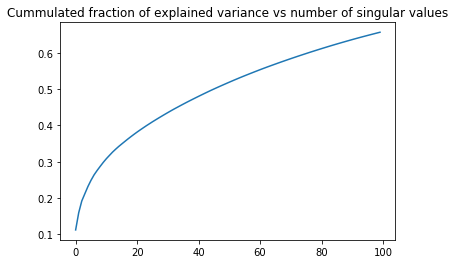

In [35]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.title('Cummulated fraction of explained variance vs number of singular values');

In [36]:
print(svd.components_.shape)
print(svd_out.shape)

(100, 9066)
(671, 100)


### Computing Similarities and Making Recommendations
Let's compute similarity between two movies, first we need to use the movies table to get the itemid that will be used with the ratings data that generated our svd.

Determine the movie ids of "Toy Story (1995)" and "Bug's Life, A (1998)".

In [37]:
movies[movies.title == "Toy Story (1995)"]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [38]:
# Item Similarity
# original similarity
def item_similarity(movieId1, movieId2):
    return cosine_similarity(ratings_pivot.loc[:,movieId1].values.reshape(1,-1),ratings_pivot.loc[:,movieId2].values.reshape(1,-1))

# transformed similarity
components = pd.DataFrame(svd.components_, columns=ratings_pivot.columns)
def item_similarity_new(movieId1, movieId2):
    return cosine_similarity(components.loc[:,movieId1].values.reshape(1,-1),components.loc[:,movieId2].values.reshape(1,-1))



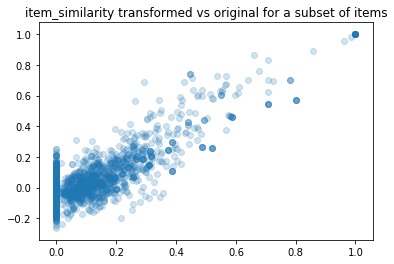

In [39]:
# plot transformed similarity vs original similarity for a few movie pairs
item_sim=[]
item_sim_new=[]
for i in range(100,9001,100):
    for j in range(100,i,100):
        r1 = item_similarity(ratings_pivot.columns[i], ratings_pivot.columns[j])
        r2 = item_similarity_new(ratings_pivot.columns[i], ratings_pivot.columns[j])
        item_sim.append(r1)
        item_sim_new.append(r2)
        
plt.scatter(x=item_sim, y=item_sim_new, alpha=0.2)
plt.title('item_similarity transformed vs original for a subset of items');

In [40]:
# User similarity
def user_similarity(userId1, userId2):
    return cosine_similarity(ratings_pivot.loc[userId1,:].values.reshape(1,-1),ratings_pivot.loc[userId2,:].values.reshape(1,-1))

def user_similarity_new(userId1, userId2):
    return cosine_similarity(svd_out[userId1,:].reshape(1,-1),svd_out[userId2,:].reshape(1,-1))

print(user_similarity(10,200)[0][0])
print(user_similarity_new(10,200)[0][0])


0.0305035317069
0.183873453785


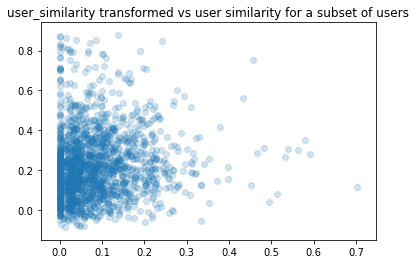

In [41]:
# Plot transformed similarity vs original similarity for some pairs of users
user_sim=[]
user_sim_new=[]
for i in range(1,600,10):
    for j in range(1,i,10):
        r1 = user_similarity(i, j)
        r2 = user_similarity_new(i, j)
        user_sim.append(r1)
        user_sim_new.append(r2)
        
plt.scatter(x=user_sim, y=user_sim_new, alpha=0.2)
plt.title('user_similarity transformed vs user similarity for a subset of users')

In [42]:
def get_similar_movies(movieId, n=5, sim=item_similarity):
    item_sims = []
    for m in ratings_pivot.columns:
        if movieId != m:
            item_sims.append((m, sim(movieId,m)[0,0]))
    res = sorted(item_sims, key=lambda x: -x[1])[:n]
    return list(map(lambda x: (movies.title[x[0]], np.round(x[1],3)), res))

In [43]:
def get_likes(title):
    id = movies[movies.title == title].index[0]
    s1 = get_similar_movies(id, n=10)
    s2 = get_similar_movies(id, sim=item_similarity_new, n=10)

    print("Titles most similar to {:s}".format(title))
    print ("{:56.56s} {:56.56s}".format(
        'Original NN: title                           similarity',
        'Transformed NN:  title                       similarity'))
    for t1,t2 in zip(s1,s2):
        print ("{:50.50s} {:.3f} {:50.50s} {:.3f}".format(*t1,*t2))

In [44]:
get_likes("Toy Story (1995)")

Titles most similar to Toy Story (1995)
Original NN: title                           similarity  Transformed NN:  title                       similarity 
Toy Story 2 (1999)                                 0.595 Toy Story 2 (1999)                                 0.497
Star Wars: Episode IV - A New Hope (1977)          0.576 Bug's Life, A (1998)                               0.409
Forrest Gump (1994)                                0.565 Monsters, Inc. (2001)                              0.408
Independence Day (a.k.a. ID4) (1996)               0.563 Shrek the Halls (2007)                             0.393
Groundhog Day (1993)                               0.548 Riding Giants (2004)                               0.382
Back to the Future (1985)                          0.537 Women, The (2008)                                  0.340
Jurassic Park (1993)                               0.535 Unfinished Life, An (2005)                         0.339
Shrek (2001)                                    

In [45]:
get_likes('Groundhog Day (1993)')

Titles most similar to Groundhog Day (1993)
Original NN: title                           similarity  Transformed NN:  title                       similarity 
Back to the Future (1985)                          0.628 Journey, The (El viaje) (1992)                     0.445
Ferris Bueller's Day Off (1986)                    0.589 When Harry Met Sally... (1989)                     0.319
Big (1988)                                         0.587 Back to the Future Part II (1989)                  0.318
Men in Black (a.k.a. MIB) (1997)                   0.586 Back to the Future (1985)                          0.317
Ghostbusters (a.k.a. Ghost Busters) (1984)         0.585 Land and Freedom (Tierra y libertad) (1995)        0.297
Princess Bride, The (1987)                         0.580 Back to the Future Part III (1990)                 0.297
Airplane! (1980)                                   0.566 Butterfly Kiss (1995)                              0.296
Raiders of the Lost Ark (Indiana Jones and t

Which users should see Toy Story? (e.g. which users -that have not rated Toy Story- would give it a high rating?)

In [46]:
(svd_out.shape, components.shape)

((671, 100), (100, 9066))

In [47]:
# gest the similarity between Toy Story and every user which gives the predicted rating
ts_ratings_ = np.dot(svd_out, components.loc[:,1].values) # loc 1 is for ToyStory
# converts numpy to a pandas data frame
ts_ratings = pd.DataFrame(ts_ratings_, columns=['ts_ratings',],  index=ratings_pivot.index)
print(ts_ratings.iloc[0:5])

        ts_ratings
userId            
1        -0.106282
2        -0.013360
3         1.331876
4         0.561741
5         1.505469


In [48]:
# filters for users who have not rated the movie rating == 0
ts_ratings[ratings_pivot.loc[:,1] == 0.0].sort_values(by='ts_ratings', ascending=False).head(10)

,ts_ratings
userId,
61,2.687120
271,2.388137
592,2.286284
295,2.221866
18,2.220766
640,2.206184
223,2.192858
42,2.176932
659,2.132402
